In [ ]:
#danaderp March 2018

In [3]:
import csv
#Implementing the Skip-Gram Model
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [5]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [7]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [8]:
#Preprocessing Part O
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
remove_terms = punctuation + '0123456789'

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    #Filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Filtering Stemmings
    filtered_tokens = [englishStemmer.stem(token) for token in filtered_tokens]
    #Filtering remove-terms
    filtered_tokens = [token for token in filtered_tokens if token not in remove_terms and len(token)>2]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [9]:
#Preprocessing Part I
remove_terms

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [10]:
#Extracting Data
filename = '../../data/cve/cve_dataset.tsv'
data = []
with open(filename, 'r') as tsv_file:
    tsv_reader = csv.reader(tsv_file, delimiter='\t')
    for line in tsv_reader:
        data.append((line[1], line[2]))

# for d in data:
#     print(d)


In [11]:
data[0][1]

'A buffer overflow in InterScan VirusWall 3.23 and 3.3 allows a remote attacker to execute arbitrary code by sending a long HELO command to the server.'

In [12]:
#Normalization
#Create a Method
corpora = [sentence[1] for sentence in data]
norm_corpora = [sentence.split(' ') for sentence in corpora]
norm_corpora = [[word.lower() for word in sent if word not in remove_terms] 
                for sent in norm_corpora]
norm_corpora = [' '.join(tok_sent) for tok_sent in norm_corpora]
norm_corpora = filter(None, normalize_corpus(norm_corpora))
norm_corpora = [tok_sent for tok_sent in norm_corpora if len(tok_sent.split()) > 2] #Len of the sentence

In [13]:
#norm_corpora

In [14]:
corpora

['A buffer overflow in InterScan VirusWall 3.23 and 3.3 allows a remote attacker to execute arbitrary code by sending a long HELO command to the server.',
 'Vulnerability in Apache httpd before 1.3.11, when configured for mass virtual hosting using mod_rewrite, or mod_vhost_alias in Apache 1.3.9, allows remote attackers to retrieve arbitrary files.',
 'Linux gpm program allows local users to cause a denial of service by flooding the /dev/gpmctl device with STREAM sockets.',
 'FreeBSD, NetBSD, and OpenBSD allow an attacker to cause a denial of service by creating a large number of socket pairs using the socketpair function, setting a large buffer size via setsockopt, then writing large buffers.',
 'Buffer overflow in KDE Kmail allows a remote attacker to cause a denial of service via an attachment with a long file name.',
 'The gnapster and knapster clients for Napster do not properly restrict access only to MP3 files, which allows remote attackers to read arbitrary files from the clien

In [15]:
#1-Building the corpus vocabulary
tokenizer_corpora = text.Tokenizer()
tokenizer_corpora.fit_on_texts(norm_corpora)

In [16]:
word2id = tokenizer_corpora.word_index
id2word = {v:k for k, v in word2id.items()}

In [17]:
# word2id

In [18]:
vocab_size = len(word2id) + 1 
embed_size = 20 # <-------- [HyperParameter]
print('Vocabulary Size Source:', vocab_size)
print('Vocabulary Sample Source:', list(word2id.items())[:10])

Vocabulary Size Source: 17769
Vocabulary Sample Source: [('vulner', 1), ('attack', 2), ('allow', 3), ('via', 4), ('remot', 5), ('version', 6), ('user', 7), ('execut', 8), ('file', 9), ('code', 10)]


In [19]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpora] #Vector of IDs of words per sentence

In [20]:
#2-Build a skip-gram [(target, context), relevancy] generator
# generate skip-grams
#Window SIZE!
w_size = 10 # <-------- [HyperParameter]
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=w_size) for wid in wids]

In [21]:
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(helo (2738), execut (8)) -> 1
(code (10), loginse (11041)) -> 0
(execut (8), krbsubdomain (17295)) -> 0
(attack (2), bfdclearcont (12841)) -> 0
(send (137), overflow (32)) -> 1
(long (270), datarebootjson (16675)) -> 0
(send (137), arbitrari (11)) -> 1
(arbitrari (11), viruswal (2395)) -> 1
(overflow (32), code (10)) -> 1
(viruswal (2395), code (10)) -> 1


In [22]:
#3-Building the skip-gram model architecture
#The functional API Version
#Receive 1 Integer between 1 and embed_size
word_input = Input(shape=(1,))

# This embedding layer will encode the input sequence
# into a sequence of dense vocab_size-dimensional vectors.
x_word = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(word_input)
x_word = Reshape((embed_size, ))(x_word)

context_input = Input(shape=(1,))

x_context = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(context_input)
x_context = Reshape((embed_size, ))(x_context)

x = Dot(axes=-1,normalize=True)([x_word, x_context])
x = Dense(1,kernel_initializer="glorot_uniform", activation="sigmoid")(x)

In [23]:
#Defining The model
model = Model(inputs=[word_input,context_input], outputs=[x])

In [24]:
#Model Compiling
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [25]:
# view model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        355380      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        355380      input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
#                  rankdir='TB').create(prog='dot', format='svg'))

In [27]:
#4-Training The Model 
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed Source {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  
    print('Epoch:', epoch, 'Loss:', loss)

Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 1362.247176709352
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 1226.6708032307215
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 1196.2331761731766
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 1158.3019983130507
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 1108.45421865955


In [28]:
#5-Getting Word Embeddings
weights = model.layers[2].get_weights()[0][1:]

In [29]:
df_embeddings = pd.DataFrame(weights, index=id2word.values())

In [30]:
df_embeddings.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
vulner,0.000171,-0.437801,0.144152,0.134643,-0.110573,-0.102357,0.057961,-0.044377,-0.059024,0.187603,-0.043670,-0.078162,-0.077881,0.070052,0.082882,-0.149043,-0.303470,0.035813,0.104500,-0.161452
attack,0.043021,-0.422656,0.086300,0.134533,-0.081861,-0.094048,0.129889,-0.061000,-0.089836,0.229786,-0.005784,-0.114341,-0.040279,0.025217,0.111005,-0.147068,-0.164146,-0.047302,0.211394,-0.078361
allow,0.053369,-0.561844,0.121438,0.150191,-0.036797,-0.157119,0.178563,-0.056567,-0.056538,0.297441,0.049825,-0.089037,-0.230641,-0.018094,0.147082,-0.061100,-0.271736,0.080563,0.266503,0.002302
via,-0.185783,-0.576823,0.027428,0.077200,0.060903,-0.200076,0.187772,0.112732,0.001474,0.415290,0.086897,-0.153539,-0.049401,0.032857,0.079497,-0.118471,-0.041250,-0.009952,0.231692,0.156854
remot,-0.074951,-0.353565,0.016138,0.016654,0.016422,0.139894,0.109363,0.023234,-0.089166,0.227232,-0.046047,-0.057214,-0.238109,0.034762,0.201832,-0.065951,-0.194480,0.080916,0.090345,0.053840
version,0.031926,-0.402740,0.124252,0.105880,-0.079602,-0.161755,0.096844,-0.005049,-0.182404,0.147564,-0.004633,-0.098642,-0.107615,0.074304,0.034390,-0.077012,-0.296719,0.163224,0.241606,-0.031351
user,0.184123,-0.485436,0.046724,0.053148,0.088723,-0.244540,0.234067,0.029530,-0.079929,0.053929,-0.100011,0.002690,-0.188049,-0.029046,0.313271,-0.143058,-0.036415,0.262188,-0.147827,-0.037986
execut,-0.073900,-0.404724,0.220534,-0.104461,-0.003888,-0.010149,0.110686,0.049595,-0.104624,0.140495,-0.050707,-0.061349,-0.071720,0.082086,0.215377,-0.139562,-0.133143,0.092822,0.101307,-0.062140
file,-0.138539,-0.393260,0.056537,-0.051577,0.021046,-0.029441,0.222240,0.005784,0.003086,0.078666,-0.036102,0.055086,-0.017755,0.064596,0.186813,-0.106649,0.003676,-0.032116,0.078437,0.143672
code,-0.101406,-0.399449,0.225957,-0.133456,0.006695,0.070998,0.129851,0.101062,-0.163603,0.074388,-0.119653,-0.053541,0.007878,0.068541,0.277932,-0.135685,-0.119262,0.125234,0.099173,-0.023777


In [31]:
df_embedding_trans = df_embeddings.T

In [32]:
df_embedding_trans.head()

,vulner,attack,allow,via,remot,version,user,execut,file,code,...,spa,tikiusertasksphp,showhistori,phpseriala,esal,synchoxid,oxconfiggetrequestparamet,coreoxconfigphp,woocommercephp,dexpress
0,0.000171,0.043021,0.053369,-0.185783,-0.074951,0.031926,0.184123,-0.073900,-0.138539,-0.101406,...,-0.018810,-0.008602,-0.005344,-0.010642,0.020563,-0.005785,-0.001800,0.008445,0.014976,0.001271
1,-0.437801,-0.422656,-0.561844,-0.576823,-0.353565,-0.402740,-0.485436,-0.404724,-0.393260,-0.399449,...,-0.010771,0.020948,-0.017616,0.011412,0.001480,-0.020168,-0.019430,0.006363,-0.003962,-0.024160
2,0.144152,0.086300,0.121438,0.027428,0.016138,0.124252,0.046724,0.220534,0.056537,0.225957,...,-0.009553,-0.008995,-0.021122,-0.006222,-0.002560,-0.003528,-0.011122,-0.013905,-0.000169,-0.002839
3,0.134643,0.134533,0.150191,0.077200,0.016654,0.105880,0.053148,-0.104461,-0.051577,-0.133456,...,0.021878,-0.003575,-0.005521,0.020992,0.021021,-0.002189,0.006101,0.020331,-0.003703,0.015827
4,-0.110573,-0.081861,-0.036797,0.060903,0.016422,-0.079602,0.088723,-0.003888,0.021046,0.006695,...,0.008498,0.012965,0.009986,-0.003516,-0.002997,-0.018567,0.008400,-0.017945,0.016237,0.022131


In [33]:
np.array(df_embedding_trans['vulner'])

array([ 1.70907704e-04, -4.37800854e-01,  1.44152269e-01,  1.34642661e-01,
       -1.10572517e-01, -1.02356844e-01,  5.79605401e-02, -4.43765409e-02,
       -5.90237565e-02,  1.87602997e-01, -4.36695442e-02, -7.81620890e-02,
       -7.78805315e-02,  7.00518787e-02,  8.28823969e-02, -1.49043441e-01,
       -3.03469688e-01,  3.58134657e-02,  1.04499795e-01, -1.61452442e-01],
      dtype=float32)

In [34]:
#Verifying Closeness
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:4]+1] 
                   for search_term in ['vulner', 'attack', 'window', 'via', 'remot', 'code', 'user','exploit']}

(17768, 17768)


In [35]:
len(distance_matrix)

17768

In [36]:
similar_words

{'vulner': ['attack', 'version', 'affect'],
 'attack': ['vulner', 'use', 'access'],
 'window': ['microsoft', 'elev', 'way'],
 'via': ['allow', 'attack', 'file'],
 'remot': ['execut', 'use', 'prior'],
 'code': ['execut', 'process', 'read'],
 'user': ['sensit', 'inform', 'permiss'],
 'exploit': ['success', 'result', 'read']}

In [37]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])

In [38]:
word_vectors

array([[ 4.30213213e-02, -4.22656417e-01,  8.63003060e-02,
         1.34533286e-01, -8.18610638e-02, -9.40476432e-02,
         1.29889056e-01, -6.10003434e-02, -8.98360163e-02,
         2.29785860e-01, -5.78449247e-03, -1.14341065e-01,
        -4.02785465e-02,  2.52173003e-02,  1.11005165e-01,
        -1.47068143e-01, -1.64146483e-01, -4.73017730e-02,
         2.11394414e-01, -7.83612132e-02],
       [ 5.33690974e-02, -5.61843991e-01,  1.21437766e-01,
         1.50190711e-01, -3.67968231e-02, -1.57118618e-01,
         1.78562641e-01, -5.65670468e-02, -5.65379933e-02,
         2.97441036e-01,  4.98249009e-02, -8.90372768e-02,
        -2.30640531e-01, -1.80935971e-02,  1.47081539e-01,
        -6.10998496e-02, -2.71735966e-01,  8.05633143e-02,
         2.66503394e-01,  2.30218470e-03],
       [ 1.84122622e-01, -4.85436231e-01,  4.67237383e-02,
         5.31484969e-02,  8.87232274e-02, -2.44539976e-01,
         2.34066933e-01,  2.95297671e-02, -7.99285024e-02,
         5.39289340e-02, -1.0

In [48]:
#T-SNE dimensionality Reduction
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

Total words: 32 	Word Embedding shapes: (32, 20)


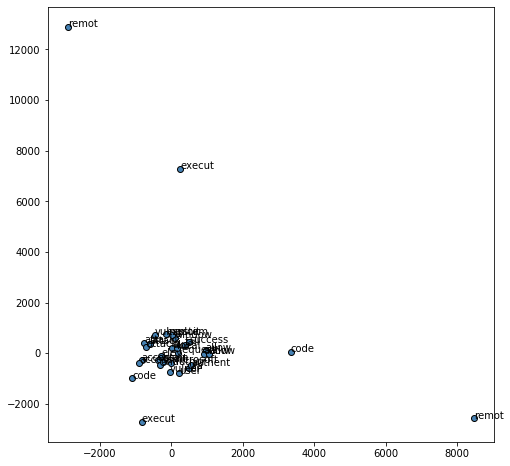

In [49]:
plt.figure(figsize=(8, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

In [50]:
#Generating Training Set
max_len_sentences = max([len(wpt.tokenize(doc)) for doc in norm_corpora]) #<------- [Parameter]
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 367


In [51]:
corpora_tensor = [[np.array(df_embedding_trans[word_]) for word_ in wpt.tokenize(doc) if word_ not in remove_terms] 
                  for doc in norm_corpora]

In [52]:
len(wpt.tokenize(norm_corpora[0]))

15

In [53]:
#BaseLine Architecture <-------
words_rows = max_len_sentences
embeddigs_cols = embed_size
input_sh = (words_rows,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 32 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [54]:
input_sh

(367, 20, 1)

In [55]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [56]:
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(1,embeddigs_cols), padding='valid',data_format="channels_last")(gram_input)

In [57]:
conv_filter_1_gram

<tf.Tensor 'conv2d/Identity:0' shape=(None, 367, 1, 32) dtype=float32>

In [58]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(3,embeddigs_cols), padding='valid')(gram_input)

In [59]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(5,embeddigs_cols), padding='valid')(gram_input)

In [60]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((words_rows-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((words_rows-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((words_rows-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [61]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [62]:
merged_vector = layers.concatenate([fully_connected_1_gram, fully_connected_3_gram, 
                                    fully_connected_5_gram], axis=-1)

integration_layer = Dropout(0.4)(merged_vector)

predictions = Dense(K, activation='softmax')(integration_layer)

In [63]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [64]:
criticality_network.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [65]:
#Corpus Generation
import csv
import random